# Assignment Sheet 2

Bruce Schultz  
bschultz@uni-bonn.de

Miguel A. Ibarra-Arellano  
ibarrarellano@gmail.com

## Exercise 1

In [34]:
# Requiered libraries
import os
import math
import palettable
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from itertools import product

In [11]:
def interpolate_by_mean(column):
    """
    Interpolates missing values by the mean
    :param column: A pandas dataframe
    :return: A pandas dataframe containing the column names which have null values
    """
    return column.fillna(int(round(column.mean()))) if any(column.isnull()) else column

In [12]:
def get_f_score (attribute, groups, exclude =[]):
    """
    Calculates the F score of an attribute between to groups (for now)
    :param data: Pandas dataframe
    :param column: Pandas Series
    :param groupby: Column with the categories
    :param exclude: List of columns to be excluded from the calculation
    """
    if attribute.name in exclude:
        return None
    else:        
        # Get means for groups
        grand_mean = attribute.mean()
        g1_mean = groups[0][attribute.name].mean() # Group 1
        g2_mean = groups[1][attribute.name].mean() # Group 2
        
        g1_diff = [(i-g1_mean)**2 for i in groups[0][attribute.name]] # Group 1
        g2_diff = [(i-g2_mean)**2 for i in groups[1][attribute.name]] # Group 2
        
        numerator = (g1_mean - grand_mean)**2 + (g2_mean - grand_mean)**2
        denom = (1/(len(groups[0][attribute.name])-1))*sum(g1_diff) + \
                (1/(len(groups[1][attribute.name])-1))*sum(g2_diff)
        
        return numerator/denom

In [13]:
def color_list(variableList):
    return ["blue" if row == 2 else "red" for row in variableList]

In [ ]:
def cluster_center(points):
    '''
    Computes the center point from a list of points
    :param points: Can be a list of lists of tuples containing points
    :return: A list with center point for each set of points provided, in numpy array format
    '''
    cluster_centers = [np.array([0, 0]) for dataset in points]
    for i in range(len(points)):
        for datapoint in points[i]:
            cluster_centers[i] = np.add(np.array(datapoint), cluster_centers[i])
        cluster_centers[i] = cluster_centers[i]/len(points[i])
    return cluster_centers

In [ ]:
def DSC(point_list):
    '''
    Computers Distance consistency for a set (or sets) of points
    :param point_list: A list of points in tuple format
    :return: Numerical computation of the Distance consistency for all points provided
    '''
    # First computer center points
    centers = cluster_center(point_list)
    #Create empty lists to store distances of the difference between each point and each centroid
    same_cluster_distances = []
    diff_cluster_distances = []
    for i in range(len(point_list)):
        for datapoint in point_list[i]:
            for j in range(len(point_list)):
                # Alternate between same centroid and diff centroids, store in list
                if i == j:
                    same_cluster_distances.append(np.linalg.norm(np.array(datapoint) - centers[i]))
                else:
                    diff_cluster_distances.append(np.linalg.norm(np.array(datapoint) - centers[j]))
    # Create counter to keep track points closer to their own centroid
    closer_points = 0
    for k in range(len(same_cluster_distances)):
        if same_cluster_distances[k] < diff_cluster_distances[k]:
            closer_points += 1
    return (100*closer_points/len(same_cluster_distances))

DSC of bareNuc and uniCelShape = 94.13447782546496
DSC of bareNuc and uniCelS = 94.70672389127324
DSC of bareNuc and blaChroma = 92.27467811158799
DSC of bareNuc and thickness = 93.8483547925608
DSC of uniCelShape and bareNuc = 94.13447782546496
DSC of uniCelShape and uniCelS = 93.41917024320458
DSC of uniCelShape and blaChroma = 93.2761087267525
DSC of uniCelShape and thickness = 94.70672389127324
DSC of uniCelS and bareNuc = 94.70672389127324
DSC of uniCelS and uniCelShape = 93.41917024320458
DSC of uniCelS and blaChroma = 92.98998569384835
DSC of uniCelS and thickness = 93.8483547925608
DSC of blaChroma and bareNuc = 92.27467811158799
DSC of blaChroma and uniCelShape = 93.2761087267525
DSC of blaChroma and uniCelS = 92.98998569384835
DSC of blaChroma and thickness = 93.41917024320458
DSC of thickness and bareNuc = 93.8483547925608
DSC of thickness and uniCelShape = 94.70672389127324
DSC of thickness and uniCelS = 93.8483547925608
DSC of thickness and blaChroma = 93.41917024320458


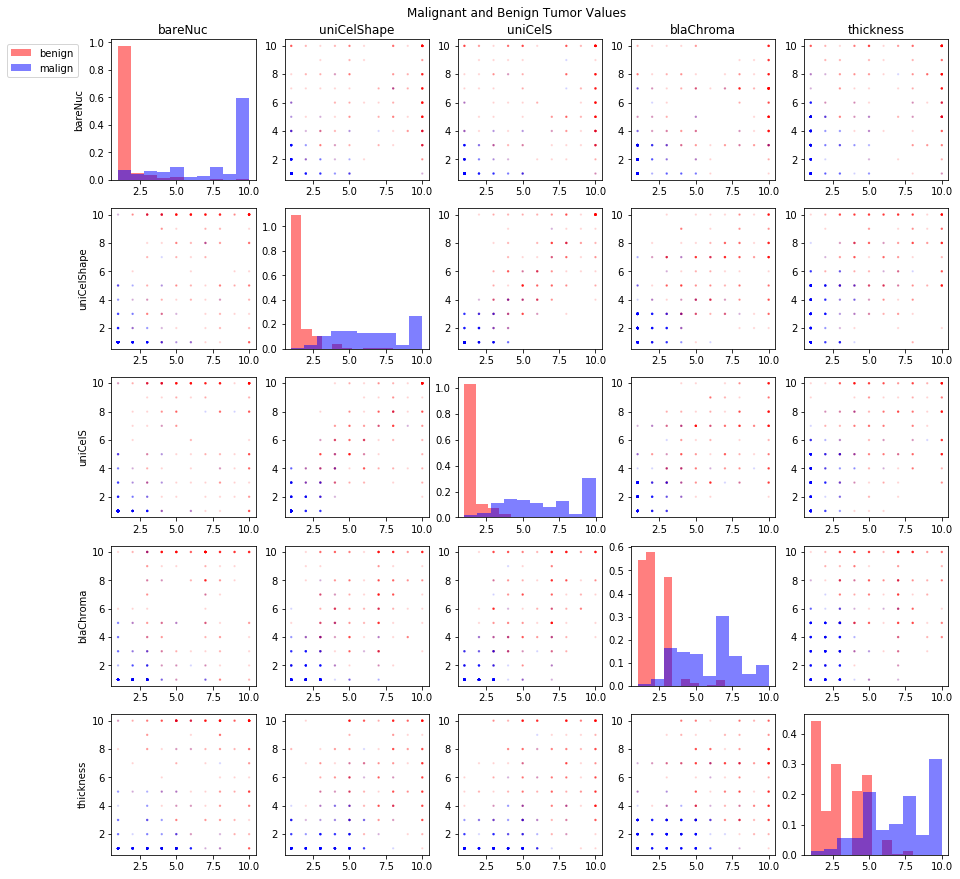

In [14]:


# input file
path = "breast-cancer-wisconsin.xlsx"

# Read file to pandasDF
data_df = pd.read_excel(os.path.abspath(path),index_col="code")

# For the momment let's just interpolate missing data by class
# Interpolating missing values to each column
data_2_imputed = data_df[data_df["class"]==2].apply(interpolate_by_mean, axis=0)
data_4_imputed = data_df[data_df["class"]==4].apply(interpolate_by_mean, axis=0)
data_imputed = pd.concat([data_4_imputed,data_2_imputed])

# Calculate F-Score for the imputed data
fscores = data_imputed.apply(get_f_score, axis=0, exclude=["class"],
                             groups=[data_2_imputed,data_4_imputed])

# Sort fscores
fscores = fscores.sort_values(ascending=False)

# Subset data based on most significant attributes
# Generate figure for plots to be plotted in
n = 5 # Number of attributes to be used
fig, subs = plt.subplots(n, n, figsize=(15, 15))
fig.suptitle('Malignant and Benign Tumor Values', x=0.5, y=0.91)

# zip together the column names and the possition on the matrix
# this will avoid using nested loops
col = product(fscores[:n].index,repeat=2)
idx = product(range(n),repeat=2)

# iterate over columns(c1,c2) combinations and plot
for attr, idx in zip(col,idx):
    # Unpacking values
    i, j         = idx
    attrx, attry = attr
    
    # For the diagonal, plot histograms
    if i==j:
        subs[i,j].hist(data_imputed[attrx][data_imputed["class"]==2], color="red",
                       alpha=0.5, histtype='bar', density=True, label= "benign")
        subs[i,j].hist(data_imputed[attrx][data_imputed["class"]==4], color="blue",
                       alpha=0.5, histtype='bar', density=True, label= "malign")

    # Otherwise plot scatterplots
    else:
        subs[i, j].scatter(data_imputed[attrx], data_imputed[attry], alpha=0.1,
                           c=color_list(data_imputed["class"].values), s=2)
        benign_a1 = list(data_imputed[data_imputed['class'] == 2][attrx])
        benign_a2 = list(data_imputed[data_imputed['class'] == 2][attry])
        malig_a1 = list(data_imputed[data_imputed['class'] == 4][attrx])
        malig_a2 = list(data_imputed[data_imputed['class'] == 4][attry])
        all_points = [list(zip(benign_a1, benign_a2)), list(zip(malig_a1, malig_a2))]
        print('DSC of {} and {} = {}'.format(attrx, attry, DSC(all_points)))
        
    # Print titles for columns
    if i==0:
        subs[i,j].set_title(attry)
        
    # Print titles for rows
    if j==0:
        subs[i,j].set_ylabel(attrx)


# Figure attributes
subs[0, 0].legend(bbox_to_anchor=(-0.2, 1.0))


fig.savefig('Scatter Plot.png')
#fig.show()

In [ ]:
#TODO answer questions

# Exercise 2

In [15]:
def runPCA(wide):
    """
    Runs PCA over a wide formated dataset
    """
    
    # Scalling data
    wide_s = wide.copy()
    wide_s["var"] = wide.std(axis=1)
    wide_s = wide_s.apply(lambda x: x/math.sqrt(x["var"]),axis=1)
    wide_s = wide_s.drop("var", axis=1)

    #Initialize PCA class with default values
    pca = PCA()

    #Get scores of PCA (Fit PCA)
    scores = pca.fit_transform(wide)

    #Get loadings
    loadings = pca.components_

    #Get aditional information out of PCA (summary)
    sd     = scores.std(axis=0)
    var    = pca.explained_variance_ratio_
    cumVar = var.cumsum()

    # Create summay file
    summary = np.array([sd,var,cumVar]).T

    # Create headers 
    header = ["PC{0}".format(x+1) for x in range(summary.shape[0])]

    # Convert loadings, scores and summaries to Pandas DataFrame rename index
    df_scores   = pd.DataFrame(data=scores, index=wide.index, columns=header)
    df_loadings = pd.DataFrame(data=loadings, index=header, columns=wide.columns)
    df_summary  = pd.DataFrame(data=summary, index=header, columns=["standard_deviation",
                "proportion_of_variance_explained","cumulative_proportion_of_variance_explained"])

    return df_scores, df_loadings, df_summary

In [35]:
def plot_hbar(ax, xticks, values, colors="b",lw=None):
    """
    This function draws an horizontal bar graph
    """
    # Calculate width for bards
    width = 1/float(len(values)) + .5

    # Calculates positions for bars
    ticks = np.arange(len(xticks)) + 0.5

    # Horizontal barplot
    ax.barh(y=ticks, width=values, height=0.8, color=colors, align='center',
            linewidth=lw)

    # Setting ticks
    ax.set_yticks(ticks)

    # Stablishing ticks rotation
    ax.set_yticklabels(xticks,rotation='horizontal')

    # Return axis
    return ax

In [37]:
def get_colors_cmappalette(elements):
    palette = palettable.colorbrewer.sequential.Blues_9
    
    # Get a color map
    mpl_colors = palette.mpl_colors
    
    # Subsetting colors as python default
    mpl_colors = mpl_colors[int(3):int(palette.number)]

    # Re calculate new colormap based on the colors.
    mpl_colormap = matplotlib.colors.LinearSegmentedColormap.from_list(
                            colors=mpl_colors, 
                            name='subseted')
    
    # Pic the ammount of colors necesary from the file
    #Creates a np array of the list rangin form 0-1
    colPosition = np.arange(0,1,1.0/len(elements))

    #Get an array of positions in the colormap 
    colPosition = np.array([x+(1.0/(len(elements)*2)) for x in colPosition])

    #Get list of colors out of the positions
    colorList = mpl_colormap(colPosition)

    #Return colorList
    return colorList

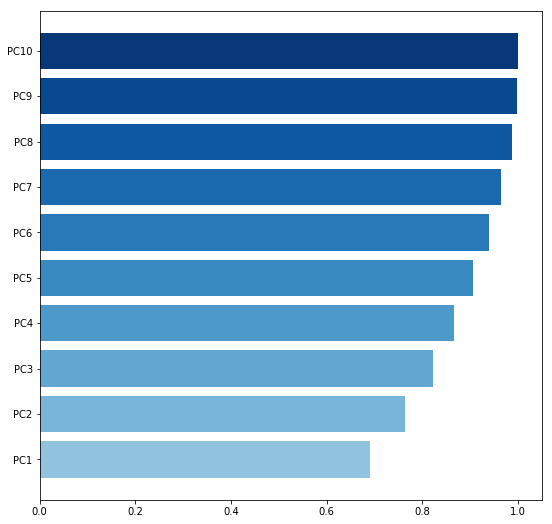

In [38]:
# input file
path = "breast-cancer-wisconsin.xlsx"

# Read file to pandasDF
data_df = pd.read_excel(os.path.abspath(path),index_col="code")

# For the momment let's just interpolate missing data by class
# Interpolating missing values to each column
data_2_imputed = data_df[data_df["class"]==2].apply(interpolate_by_mean, axis=0)
data_4_imputed = data_df[data_df["class"]==4].apply(interpolate_by_mean, axis=0)
data_imputed = pd.concat([data_4_imputed,data_2_imputed])

# Running PCA
scores, loadings, summary = runPCA(data_imputed)

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
colors = get_colors_cmappalette(summary.index)
ax = plot_hbar(ax, xticks=summary.index.values, colors=colors,
               values = summary["cumulative_proportion_of_variance_explained"])

In [ ]:
palettable.